In [ ]:
%matplotlib inline

In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.linear_model
from datetime import datetime
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict
import tabulate

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Load and plot sample data

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist.data.shape

(70000, 784)

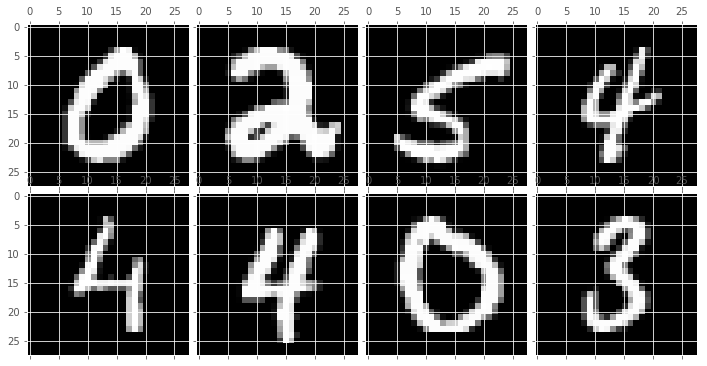

In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid

N_ROWS = 2
N_COLS = 4

fig = plt.figure(1, (12, 18))
plt.gray()
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(N_ROWS, N_COLS),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )    

for i in range(N_ROWS * N_COLS):
    index = np.random.randint(0, mnist.data.shape[0]) 
    digit = mnist.data[index]
    digit = digit.reshape((28, 28))
    grid[i].matshow(digit) 
    
plt.show() 

In [5]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

## Two-class train and test split
For each of the two classes I chose (7 and 8), read out the indices of the relevant class, pick 15 entries to serve a test set for that class, and use the rest as the training set. Then combine the two into training and test sets.

Set seed to make sure it's repeatable, and display the shapes as a sanity check.

In [6]:
from sklearn.model_selection import train_test_split

data_indices = np.concatenate((np.where(mnist.target == 7)[0], np.where(mnist.target == 8)[0]))

X = np.take(mnist.data, data_indices, axis=0)
y = np.take(mnist.target, data_indices, axis=0)

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    stratify=y, random_state=RANDOM_SEED)

X_train_small, X_test_small, y_train_small, y_test_small = \
    train_test_split(X, y, train_size=0.2, test_size=0.05, stratify=y, random_state=RANDOM_SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(14118, 784) (14118,)


((12706, 784), (1412, 784), (12706,), (1412,))

## Fit SVMs with different kernels

Cross-validating over the choice of $C$, the penalty parameter, the degree of the polynomial kernel, and $\gamma$, the reciprocal of the variance of the RBF and polynomial kernels.

I will use X_small_train (~1400 examples per class) to cross-validate the choice of parameters, and then use the best values to compare the training times and error rates.

In [7]:
# report function from: 
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from collections import namedtuple

def log_sample_C(loc=0, scale=1, size=1, random_state=None):
    return np.exp(uniform.rvs(loc=0, scale=4, size=size, random_state=random_state))[0]

CSampler = namedtuple('CSampler', 'rvs')
c_sampler = CSampler(rvs=log_sample_C)


def log_sample_gamma(loc=0, scale=1, size=1, random_state=None):
    return np.exp(uniform.rvs(loc=-20, scale=20, size=size, random_state=random_state))[0]

GammaSampler = namedtuple('GammaSampler', 'rvs')
gamma_sampler = GammaSampler(rvs=log_sample_gamma)

KERNELS_TO_PARAMETERS = dict(
    linear=dict(C=c_sampler),
    rbf=dict(C=c_sampler, gamma=gamma_sampler),
    poly=dict(C=c_sampler, gamma=gamma_sampler, degree=randint(2, 6))
)

cross_validation_results = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for kernel in KERNELS_TO_PARAMETERS:
        print(kernel)
        svm = SVC(kernel=kernel, verbose=True)
        search_cv = RandomizedSearchCV(svm, n_iter=12, scoring='accuracy', n_jobs=4, 
                                       verbose=1, random_state=RANDOM_SEED,
                                       param_distributions=KERNELS_TO_PARAMETERS[kernel])
        search_cv.fit(X=X_train_small, y=y_train_small)
        cross_validation_results[kernel] = search_cv
        report(search_cv.cv_results_)
    

linear
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    4.6s finished


[LibSVM]Model with rank: 1
Mean validation score: 0.988 (std: 0.004)
Parameters: {'C': 2.7021304292631889}

Model with rank: 1
Mean validation score: 0.988 (std: 0.004)
Parameters: {'C': 6.0490527177389888}

Model with rank: 1
Mean validation score: 0.988 (std: 0.004)
Parameters: {'C': 5.1746060569148051}

Model with rank: 1
Mean validation score: 0.988 (std: 0.004)
Parameters: {'C': 2.8326106102297364}

Model with rank: 1
Mean validation score: 0.988 (std: 0.004)
Parameters: {'C': 32.511138489964509}

Model with rank: 1
Mean validation score: 0.988 (std: 0.004)
Parameters: {'C': 2.0962702802526647}

Model with rank: 1
Mean validation score: 0.988 (std: 0.004)
Parameters: {'C': 1.0818209668556438}

Model with rank: 1
Mean validation score: 0.988 (std: 0.004)
Parameters: {'C': 45.286461560185913}

Model with rank: 1
Mean validation score: 0.988 (std: 0.004)
Parameters: {'C': 15.207720384298495}

Model with rank: 1
Mean validation score: 0.988 (std: 0.004)
Parameters: {'C': 7.00309718500

[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   54.6s finished


[LibSVM]Model with rank: 1
Mean validation score: 0.996 (std: 0.001)
Parameters: {'C': 5.1746060569148051, 'gamma': 3.7587613265430368e-07}

Model with rank: 2
Mean validation score: 0.996 (std: 0.001)
Parameters: {'C': 17.876864556899822, 'gamma': 2.9254881033213171e-07}

Model with rank: 3
Mean validation score: 0.994 (std: 0.000)
Parameters: {'C': 12.074790018517243, 'gamma': 3.5596316174344359e-08}

poly
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   16.2s finished


[LibSVM]Model with rank: 1
Mean validation score: 0.995 (std: 0.001)
Parameters: {'C': 2.7021304292631889, 'degree': 2, 'gamma': 0.0013409497607972584}

Model with rank: 1
Mean validation score: 0.995 (std: 0.001)
Parameters: {'C': 2.0962702802526647, 'degree': 2, 'gamma': 0.050249177104249795}

Model with rank: 1
Mean validation score: 0.995 (std: 0.001)
Parameters: {'C': 47.470443699444594, 'degree': 2, 'gamma': 0.47683104037266971}



In [9]:
results = defaultdict(dict)

for kernel in cross_validation_results:
    print(kernel)
    svm = cross_validation_results[kernel].best_estimator_
        
    def fit_function():
        return svm.fit(X_train, y_train)
        
    train_time, train_result = timeit.timeit(fit_function, number=1)
    results[kernel]['train_time'] = train_time
    
    def classify_function():
        return svm.predict(X_test)
        
    classification_time, classification_result = timeit.timeit(classify_function, number=1)
    results[kernel]['classification_time'] = classification_time
    
    prediction_accuracy = np.sum(y_test == classification_result) / y_test.shape[0]
    results[kernel]['classification_accuracy'] = prediction_accuracy
    print()

linear
[LibSVM]
rbf
[LibSVM]
poly
[LibSVM]


In [10]:
headers = ('kernel_type', 'train_time', 'classification_time', 'classification_accuracy')
table_data = [[kernel] + [results[kernel][header] for header in headers[1:]] for kernel in cross_validation_results]
print(tabulate.tabulate(table_data, headers, tablefmt='fancy_grid'))

╒═══════════════╤══════════════╤═══════════════════════╤═══════════════════════════╕
│ kernel_type   │   train_time │   classification_time │   classification_accuracy │
╞═══════════════╪══════════════╪═══════════════════════╪═══════════════════════════╡
│ linear        │      5.36562 │              0.330686 │                  0.98796  │
├───────────────┼──────────────┼───────────────────────┼───────────────────────────┤
│ rbf           │     10.9164  │              1.15145  │                  0.998584 │
├───────────────┼──────────────┼───────────────────────┼───────────────────────────┤
│ poly          │      5.42338 │              0.539599 │                  0.999292 │
╘═══════════════╧══════════════╧═══════════════════════╧═══════════════════════════╛


## Try classifying all ten classes

## Update - it turns out one does not simply train an SVM to classify MNIST on their laptop with the entire data set. It crashes. Oh well. Leaveing the code here for posterity.

In [ ]:
from sklearn.model_selection import train_test_split

X_full = mnist.data
y_full = mnist.target

print(X_full.shape, y_full.shape)

X_full_train, X_full_test, y_full_train, y_full_test = \
    train_test_split(X_full, y_full, test_size=0.1, stratify=y_full, random_state=RANDOM_SEED)

X_full_train_small, X_full_test_small, y_full_train_small, y_full_test_small = \
    train_test_split(X_full, y_full, train_size=0.1, test_size=0.05, stratify=y_full, random_state=RANDOM_SEED)

X_full_train.shape, X_full_train_small.shape, y_full_train.shape, y_full_train.shape

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from collections import namedtuple

def log_sample_C(loc=0, scale=1, size=1, random_state=None):
    return np.exp(uniform.rvs(loc=0, scale=4, size=size, random_state=random_state))[0]

CSampler = namedtuple('CSampler', 'rvs')
c_sampler = CSampler(rvs=log_sample_C)


def log_sample_gamma(loc=0, scale=1, size=1, random_state=None):
    return np.exp(uniform.rvs(loc=-20, scale=20, size=size, random_state=random_state))[0]

GammaSampler = namedtuple('GammaSampler', 'rvs')
gamma_sampler = GammaSampler(rvs=log_sample_gamma)

KERNELS_TO_PARAMETERS = dict(
    linear=dict(C=c_sampler),
    rbf=dict(C=c_sampler, gamma=gamma_sampler),
    poly=dict(C=c_sampler, gamma=gamma_sampler, degree=randint(2, 6))
)

full_cross_validation_results = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for kernel in KERNELS_TO_PARAMETERS:
        print(kernel)
        svm = SVC(kernel=kernel, verbose=True)
        search_cv = RandomizedSearchCV(svm, n_iter=8, scoring='accuracy', n_jobs=4, 
                                       verbose=1, random_state=RANDOM_SEED,
                                       param_distributions=KERNELS_TO_PARAMETERS[kernel])
        search_cv.fit(X=X_full_train_small, y=y_full_train_small)
        full_cross_validation_results[kernel] = search_cv
        report(search_cv.cv_results_)
    

In [ ]:
full_results = defaultdict(dict)

for kernel in full_cross_validation_results:
    print(kernel)
    svm = full_cross_validation_results[kernel].best_estimator_
        
    def fit_function():
        return svm.fit(X_full_train, y_full_train)
        
    train_time, train_result = timeit.timeit(fit_function, number=1)
    full_results[kernel]['train_time'] = train_time
    
    def classify_function():
        return svm.predict(X_full_test)
        
    classification_time, classification_result = timeit.timeit(classify_function, number=1)
    full_results[kernel]['classification_time'] = classification_time
    
    prediction_accuracy = np.sum(y_full_test == classification_result) / y_full_test.shape[0]
    full_results[kernel]['classification_accuracy'] = prediction_accuracy
    print()

In [ ]:
headers = ('kernel_type', 'train_time', 'classification_time', 'classification_accuracy')
table_data = [[kernel] + [full_results[kernel][header] for header in headers[1:]] 
              for kernel in full_cross_validation_results]
print(tabulate.tabulate(table_data, headers, tablefmt='fancy_grid'))

## Try to classify on LDA'd data

First with the LDA's classifier, then with an SVM on LDA'd data

Reloading the data in order to center it before splitting into train, small train, and test

In [11]:
from sklearn.model_selection import train_test_split

X_full = mnist.data 
X_full -= np.mean(X_full, axis=0, dtype=np.dtype('uint8'))
y_full = mnist.target

print(X_full.shape, y_full.shape)

X_full_train, X_full_test, y_full_train, y_full_test = \
    train_test_split(X_full, y_full, test_size=0.1, stratify=y_full, random_state=RANDOM_SEED)

X_full_train_small, X_full_test_small, y_full_train_small, y_full_test_small = \
    train_test_split(X_full, y_full, train_size=0.1, test_size=0.05, stratify=y_full, random_state=RANDOM_SEED)

X_full_train.shape, X_full_train_small.shape, y_full_train.shape, y_full_train.shape

(70000, 784) (70000,)


((63000, 784), (7000, 784), (63000,), (63000,))

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(X_full_train, y_full_train)

print('Train accuracy:', sum(lda.predict(X_full_train) == y_full_train) / X_full_train.shape[0])
print('Test accuracy:', sum(lda.predict(X_full_test) == y_full_test) / X_full_test.shape[0])

/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Train accuracy: 0.873650793651
Test accuracy: 0.857285714286


In [13]:
X_full_train_LDA = lda.transform(X_full_train)
X_full_train_small_LDA = lda.transform(X_full_train_small)
X_full_test_LDA = lda.transform(X_full_test)

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from collections import namedtuple

def log_sample_C(loc=0, scale=1, size=1, random_state=None):
    return np.exp(uniform.rvs(loc=0, scale=4, size=size, random_state=random_state))[0]

CSampler = namedtuple('CSampler', 'rvs')
c_sampler = CSampler(rvs=log_sample_C)


def log_sample_gamma(loc=0, scale=1, size=1, random_state=None):
    return np.exp(uniform.rvs(loc=-20, scale=20, size=size, random_state=random_state))[0]

GammaSampler = namedtuple('GammaSampler', 'rvs')
gamma_sampler = GammaSampler(rvs=log_sample_gamma)

KERNELS_TO_PARAMETERS = dict(
    linear=dict(C=c_sampler),
    rbf=dict(C=c_sampler, gamma=gamma_sampler),
    poly=dict(C=c_sampler, gamma=gamma_sampler, degree=randint(2, 6))
)

LDA_cross_validation_results = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for kernel in KERNELS_TO_PARAMETERS:
        print(kernel)
        svm = SVC(kernel=kernel, verbose=True)
        search_cv = RandomizedSearchCV(svm, n_iter=12, scoring='accuracy', n_jobs=4, 
                                       verbose=1, random_state=RANDOM_SEED,
                                       param_distributions=KERNELS_TO_PARAMETERS[kernel])
        search_cv.fit(X=X_full_train_small_LDA, y=y_full_train_small)
        LDA_cross_validation_results[kernel] = search_cv
        report(search_cv.cv_results_)
    

linear
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   12.1s finished


[LibSVM]Model with rank: 1
Mean validation score: 0.894 (std: 0.004)
Parameters: {'C': 2.7021304292631889}

Model with rank: 1
Mean validation score: 0.894 (std: 0.004)
Parameters: {'C': 2.8326106102297364}

Model with rank: 1
Mean validation score: 0.894 (std: 0.003)
Parameters: {'C': 32.511138489964509}

Model with rank: 1
Mean validation score: 0.894 (std: 0.003)
Parameters: {'C': 1.0818209668556438}

Model with rank: 1
Mean validation score: 0.894 (std: 0.003)
Parameters: {'C': 45.286461560185913}

Model with rank: 1
Mean validation score: 0.894 (std: 0.003)
Parameters: {'C': 15.207720384298495}

Model with rank: 1
Mean validation score: 0.894 (std: 0.003)
Parameters: {'C': 47.470443699444594}

rbf
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   21.9s finished


[LibSVM]Model with rank: 1
Mean validation score: 0.890 (std: 0.002)
Parameters: {'C': 33.869426586813574, 'gamma': 4.0317270284562337e-05}

Model with rank: 2
Mean validation score: 0.887 (std: 0.009)
Parameters: {'C': 1.0818209668556438, 'gamma': 0.39260181664842708}

Model with rank: 3
Mean validation score: 0.886 (std: 0.003)
Parameters: {'C': 15.207720384298495, 'gamma': 3.4718513987424185e-05}

poly
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   29.0s finished


[LibSVM]Model with rank: 1
Mean validation score: 0.881 (std: 0.006)
Parameters: {'C': 39.756175741180279, 'degree': 5, 'gamma': 0.074863693941416135}

Model with rank: 2
Mean validation score: 0.877 (std: 0.004)
Parameters: {'C': 2.0962702802526647, 'degree': 2, 'gamma': 0.050249177104249795}

Model with rank: 3
Mean validation score: 0.862 (std: 0.005)
Parameters: {'C': 47.470443699444594, 'degree': 2, 'gamma': 0.47683104037266971}



In [15]:
LDA_results = defaultdict(dict)

for kernel in LDA_cross_validation_results:
    print(kernel)
    svm = LDA_cross_validation_results[kernel].best_estimator_
        
    def fit_function():
        return svm.fit(X_full_train_LDA, y_full_train)
        
    train_time, train_result = timeit.timeit(fit_function, number=1)
    LDA_results[kernel]['train_time'] = train_time
    
    def classify_function():
        return svm.predict(X_full_test_LDA)
        
    classification_time, classification_result = timeit.timeit(classify_function, number=1)
    LDA_results[kernel]['classification_time'] = classification_time
    
    prediction_accuracy = np.sum(y_full_test == classification_result) / y_full_test.shape[0]
    LDA_results[kernel]['classification_accuracy'] = prediction_accuracy
    print()

linear
[LibSVM]
rbf
[LibSVM]
poly
[LibSVM]


In [16]:
headers = ('kernel_type', 'train_time', 'classification_time', 'classification_accuracy')
table_data = [[kernel] + [LDA_results[kernel][header] for header in headers[1:]] 
              for kernel in LDA_cross_validation_results]
print(tabulate.tabulate(table_data, headers, tablefmt='fancy_grid'))

╒═══════════════╤══════════════╤═══════════════════════╤═══════════════════════════╕
│ kernel_type   │   train_time │   classification_time │   classification_accuracy │
╞═══════════════╪══════════════╪═══════════════════════╪═══════════════════════════╡
│ linear        │      40.0773 │               2.0254  │                  0.877286 │
├───────────────┼──────────────┼───────────────────────┼───────────────────────────┤
│ rbf           │      28.3614 │               4.08981 │                  0.876    │
├───────────────┼──────────────┼───────────────────────┼───────────────────────────┤
│ poly          │      48.4143 │               1.78968 │                  0.895571 │
╘═══════════════╧══════════════╧═══════════════════════╧═══════════════════════════╛


## Try to classify on PCA-reduced data

In [17]:
from sklearn.decomposition import PCA

pca = PCA(whiten=True, copy=True)
pca.fit(X_full_train)
variance_diffs = np.ediff1d(pca.explained_variance_ratio_)

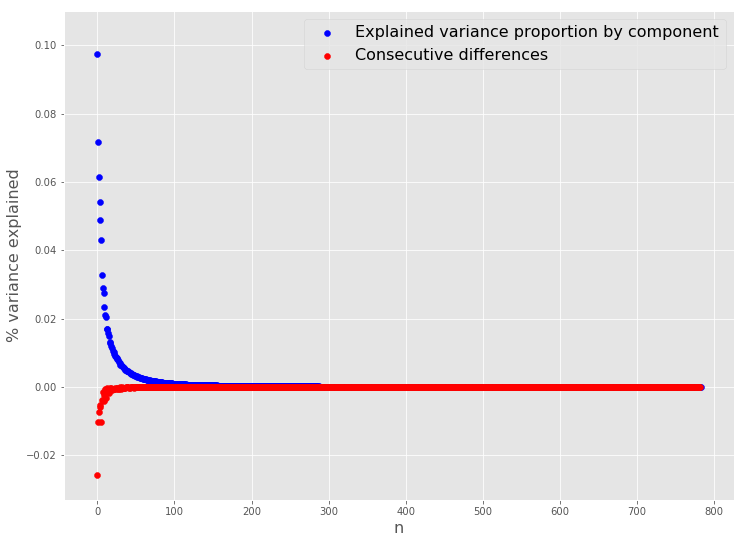

In [18]:
plt.figure(figsize=(12, 9))

plt.scatter(list(range(pca.explained_variance_ratio_.shape[0])), pca.explained_variance_ratio_, 
    color='blue', label='Explained variance proportion by component')

plt.scatter(list(range(variance_diffs.shape[0])), variance_diffs, 
    color='red', label='Consecutive differences')

plt.legend(loc=1, fontsize=16)
plt.xlabel(r'n', size=16)
plt.ylabel(r'% variance explained', size=16)
plt.show()

## Let's focus on the first 25

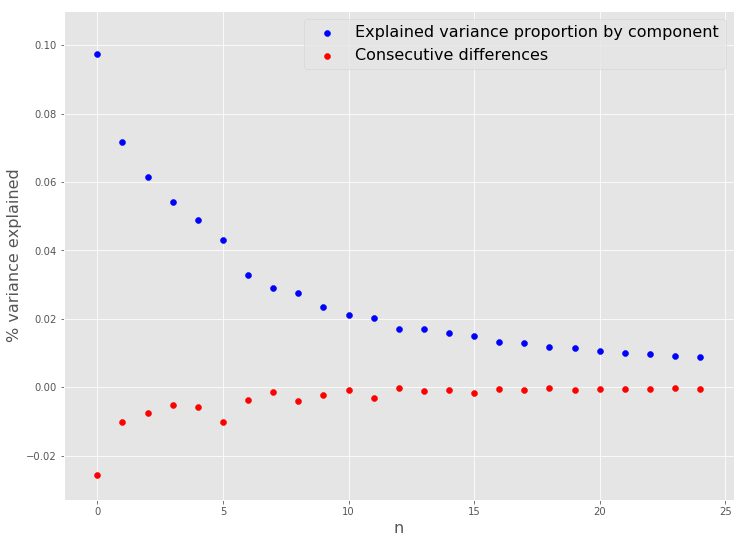

In [19]:
plt.figure(figsize=(12, 9))

NUM_ITEMS = 25

plt.scatter(list(range(NUM_ITEMS)), pca.explained_variance_ratio_[:NUM_ITEMS], 
    color='blue', label='Explained variance proportion by component')

plt.scatter(list(range(NUM_ITEMS)), variance_diffs[:NUM_ITEMS], 
    color='red', label='Consecutive differences')

plt.legend(loc=1, fontsize=16)
plt.xlabel(r'n', size=16)
plt.ylabel(r'% variance explained', size=16)
plt.show()

## Looks like the first ~12 components are a reasonable stopping point

In [20]:
N_TOP_COMPONENTS = 12

pca_top_components = PCA(n_components=N_TOP_COMPONENTS, whiten=True, copy=True)

X_full_train_PCA = pca_top_components.fit_transform(X_full_train)
X_full_train_small_PCA = pca_top_components.transform(X_full_train_small)
X_full_test_PCA = pca_top_components.transform(X_full_test)

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from collections import namedtuple

def log_sample_C(loc=0, scale=1, size=1, random_state=None):
    return np.exp(uniform.rvs(loc=0, scale=4, size=size, random_state=random_state))[0]

CSampler = namedtuple('CSampler', 'rvs')
c_sampler = CSampler(rvs=log_sample_C)


def log_sample_gamma(loc=0, scale=1, size=1, random_state=None):
    return np.exp(uniform.rvs(loc=-20, scale=20, size=size, random_state=random_state))[0]

GammaSampler = namedtuple('GammaSampler', 'rvs')
gamma_sampler = GammaSampler(rvs=log_sample_gamma)

KERNELS_TO_PARAMETERS = dict(
    linear=dict(C=c_sampler),
    rbf=dict(C=c_sampler, gamma=gamma_sampler),
    poly=dict(C=c_sampler, gamma=gamma_sampler, degree=randint(2, 6))
)

PCA_cross_validation_results = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for kernel in KERNELS_TO_PARAMETERS:
        print(kernel)
        svm = SVC(kernel=kernel, verbose=True)
        search_cv = RandomizedSearchCV(svm, n_iter=12, scoring='accuracy', n_jobs=4, 
                                       verbose=1, random_state=RANDOM_SEED,
                                       param_distributions=KERNELS_TO_PARAMETERS[kernel])
        search_cv.fit(X=X_full_train_small_PCA, y=y_full_train_small)
        PCA_cross_validation_results[kernel] = search_cv
        report(search_cv.cv_results_)
    

linear
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   13.7s finished


[LibSVM]Model with rank: 1
Mean validation score: 0.863 (std: 0.004)
Parameters: {'C': 1.0818209668556438}

Model with rank: 2
Mean validation score: 0.863 (std: 0.003)
Parameters: {'C': 2.8326106102297364}

Model with rank: 3
Mean validation score: 0.863 (std: 0.004)
Parameters: {'C': 5.1746060569148051}

rbf
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   27.9s finished


[LibSVM]Model with rank: 1
Mean validation score: 0.930 (std: 0.005)
Parameters: {'C': 1.0818209668556438, 'gamma': 0.39260181664842708}

Model with rank: 2
Mean validation score: 0.905 (std: 0.008)
Parameters: {'C': 1.9242584070436997, 'gamma': 0.7141490540028671}

Model with rank: 3
Mean validation score: 0.825 (std: 0.003)
Parameters: {'C': 33.869426586813574, 'gamma': 4.0317270284562337e-05}

poly
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   20.6s finished


[LibSVM]Model with rank: 1
Mean validation score: 0.894 (std: 0.005)
Parameters: {'C': 39.756175741180279, 'degree': 5, 'gamma': 0.074863693941416135}

Model with rank: 2
Mean validation score: 0.880 (std: 0.003)
Parameters: {'C': 2.0962702802526647, 'degree': 2, 'gamma': 0.050249177104249795}

Model with rank: 3
Mean validation score: 0.864 (std: 0.011)
Parameters: {'C': 47.470443699444594, 'degree': 2, 'gamma': 0.47683104037266971}



In [22]:
PCA_results = defaultdict(dict)

for kernel in PCA_cross_validation_results:
    print(kernel)
    svm = PCA_cross_validation_results[kernel].best_estimator_
        
    def fit_function():
        return svm.fit(X_full_train_PCA, y_full_train)
        
    train_time, train_result = timeit.timeit(fit_function, number=1)
    PCA_results[kernel]['train_time'] = train_time
    
    def classify_function():
        return svm.predict(X_full_test_PCA)
        
    classification_time, classification_result = timeit.timeit(classify_function, number=1)
    PCA_results[kernel]['classification_time'] = classification_time
    
    prediction_accuracy = np.sum(y_full_test == classification_result) / y_full_test.shape[0]
    PCA_results[kernel]['classification_accuracy'] = prediction_accuracy
    print()

linear
[LibSVM]
rbf
[LibSVM]
poly
[LibSVM]


In [23]:
headers = ('kernel_type', 'train_time', 'classification_time', 'classification_accuracy')
table_data = [[kernel] + [PCA_results[kernel][header] for header in headers[1:]] 
              for kernel in PCA_cross_validation_results]
print(tabulate.tabulate(table_data, headers, tablefmt='fancy_grid'))

╒═══════════════╤══════════════╤═══════════════════════╤═══════════════════════════╕
│ kernel_type   │   train_time │   classification_time │   classification_accuracy │
╞═══════════════╪══════════════╪═══════════════════════╪═══════════════════════════╡
│ linear        │      37.6508 │               3.2631  │                  0.859429 │
├───────────────┼──────────────┼───────────────────────┼───────────────────────────┤
│ rbf           │      67.6765 │               4.8543  │                  0.958714 │
├───────────────┼──────────────┼───────────────────────┼───────────────────────────┤
│ poly          │      21.1726 │               1.93992 │                  0.941571 │
╘═══════════════╧══════════════╧═══════════════════════╧═══════════════════════════╛


# Conclusion

Turns out that SVMs do quite a nice job of classifying MNIST digits. In the two-class case, all three models trained achieve a test accuracy of over 98%, which is objectively fantastic. The RBF kernel requires about twice as much computation as the other two, while not delivering any improvement in performance.

On the other hand, if we reduce the dimensionality of the data and train with the entire dataset, some things change. Fasinatingly, it appears that on the LDA reduced data, the RBF kernel actually downgrades performance, compared to the linear kernel. This might be explained by the fact that LDA already models the data as Gaussians, and tries to separate them in the reduced dimension expression, so could it be that the RBF kernel attempts to counteract that somehow? (_Note: do you think this would be interesting to investigate further?_) The polynomial kernels appear to deliver the best combination of accuracy _and_ train/classification time, including beating the linear kernel in train time, which I found surprising (particularly since the cross-validation chose polynomials of degree 5). 

On the PCA-reduced data, RBF finally manages to deliver an increase in accuracy, to almost 96% (on all 10 MNIST classes), albeit at more than double the training and classification time of the polynomial kerne (for an increase of 1.7%). 

## Code

As always, the code is available on my GitHub here: https://github.com/guydav/minerva/blob/master/notebooks/CS156/8.X%20MNIST%20Clustering.ipynb